# How to rediscover the Higgs boson yourself! - Neural Network
This notebook uses ATLAS Open Data http://opendata.atlas.cern to show you the steps to rediscover the Higgs boson yourself!

The idea is that you improve upon the example Neural Network to increase the ratio of signal ($H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$) to background ($Z, t\bar{t}, ZZ \rightarrow \ell\ell\ell\ell$)

First, try to reduce the amount of $Z$ and $t\bar{t}$ background, since these are quite different to the signal.

Then, try to reduce the amount of $ZZ \rightarrow \ell\ell\ell\ell$, whilst keeping $H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$ signal

The datasets used in this notebook have already been filtered to include at least 4 leptons per event, so that processing is quicker.

This notebook was inspired by https://github.com/FNALLPC/machine-learning-hats/blob/master/3-dense.ipynb

<!-- <CENTER><img src="../HZZ_feynman.pdf" style="width:40%"></CENTER> -->

## First time setup
This first cell only needs to be run the first time you open this notebook on your computer. 

If you close jupyter and re-open on the same computer, you won't need to run this first cell again.

If you re-open on binder, you will need to run this cell again.

If you run into a problem of "uproot not being available", Kernel -> Restart & Run All

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade --user pip
!{sys.executable} -m pip install -U numpy pandas uproot matplotlib keras scikit-learn --user

## To setup everytime
Cell -> Run All Below

to be done every time you re-open this notebook

In [1]:
import uproot
import pandas as pd
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import glob
import random

import infofile

In [2]:
lumi = 1000
                                                                                                                                  
tuple_path = "../Input/"

stack_order = ['data',r'$Z,t\bar{t}$','ZZ',r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$']

In [3]:
samples = {

    'data': {
        'list' : ['DataEgamma','DataMuons']
    },

    r'$Z,t\bar{t}$' : {
        'list' : ['Zee','Zmumu','ttbar_lep'],
        'color' : "#8700da"
    },

    'ZZ' : {
        'list' : ['ZZ'],
        'color' : "#f90000"
    },

    r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$' : {
        'list' : ['ggH125_ZZ4lep','VBFH125_ZZ4lep'],
        'color' : "#4faeff"
    }

}

In [4]:
def get_data_from_files():

    data = {}

    for s in samples:
        print(s+':')
        frames = []
        for val in samples[s]['list']:
            prefix = "MC/skim.mc_"
            if s == 'data':
                prefix = "Data/skim."
            else: prefix += str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".root"
            print(fileString)
            f = glob.glob(fileString,recursive=False)[0]
            if f != "":
                temp = read_file(f,val)
                frames.append(temp)
            else:
                print("Error: "+val+" not found!")
        data[s] = pd.concat(frames)

    return data

In [5]:
def mllll_window(mllll):
    return 120 < mllll < 130

In [6]:
def calc_weight(mcWeight,scaleFactor_PILEUP,scaleFactor_ELE,
                scaleFactor_MUON, scaleFactor_TRIGGER):
    return mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_TRIGGER

In [7]:
def get_xsec_weight(totalWeight,sample):
    info = infofile.infos[sample]
    weight = (lumi*info["xsec"])/(info["sumw"]*info["red_eff"])
    weight *= totalWeight
    return weight

In [8]:
def correlations(data, title, **kwds):
    """Calculate pairwise correlation between features.
    
    Extra arguments are passed on to DataFrame.corr()
    """
    # simply call df.corr() to get a table of
    # correlation values if you do not need
    # the fancy plotting
    corrmat = data.corr(**kwds)

    fig, ax1 = plt.subplots(ncols=1, figsize=(6,5))
    
    opts = {'cmap': plt.get_cmap("RdBu"),
            'vmin': -1, 'vmax': +1}
    heatmap1 = ax1.pcolor(corrmat, **opts)
    plt.colorbar(heatmap1, ax=ax1)

    ax1.set_title(title+" Correlations")

    labels = corrmat.columns.values
    for ax in (ax1,):
        # shift location of ticks to center of the bins
        ax.set_xticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_yticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_xticklabels(labels, minor=False, ha='right', rotation=70)
        ax.set_yticklabels(labels, minor=False)
        
    plt.tight_layout()

In [9]:
def plot_data(data):

    bins = [80 + x*5 for x in range(35) ]
    data_x = [82.5 + x*5 for x in range(34) ]

    data_mllll = []
    data_mllll_errors = []

    mc_mllll = []
    mc_weights = []
    mc_colors = []
    mc_labels = []
    mc_in_mllll_window = [] # list for numbers of MC events with 120 < mllll < 130 GeV

    for s in stack_order:
        if s == "data":
            data_mllll,_ = np.histogram(data[s].mllll.values, bins=bins)
            data_mllll_errors = np.sqrt(data_mllll)
        else:
            mc_labels.append(s)
            mc_mllll.append(data[s].mllll.values)
            mc_colors.append(samples[s]['color'])
            mc_weights.append(data[s].totalWeight.values)
            mc_in_mllll_window.append([data[s].totalWeight.values[mllll_iter] for mllll_iter in range(len(data[s].mllll.values)) if 120 < data[s].mllll.values[mllll_iter] < 130])
    
    HZZ_in_mllll_window = sum(mc_in_mllll_window[2]) # number signal MC events with 120 < mllll < 130 GeV
    background_in_mllll_window = sum(mc_in_mllll_window[0]+mc_in_mllll_window[1]) # number background MC events with 120 < mllll < 130 GeV
    SoversqrtB = HZZ_in_mllll_window/math.sqrt(background_in_mllll_window) # calculate significance
    print('Signal/sqrt(Background) for 120<mllll<130 '+str(SoversqrtB))
    
    top = np.amax(data_mllll)+math.sqrt(np.amax(data_mllll))

    plt.figure()
    plt.hist(mc_mllll,bins=bins,weights=mc_weights,stacked=True,color=mc_colors, label=mc_labels)
    plt.errorbar( x=data_x, y=data_mllll, yerr=data_mllll_errors, fmt='ko', label='Data')

    #X = np.arange(115,135,5) # gives list [115,120,125,130]
    #data_in_window = data_mllll[7:11] # gives list of data y value for [115,120,125,130]
    #x = np.sum(X*data_in_window)/np.sum(data_in_window) # Gaussian mean
    #width = np.sqrt(np.abs(np.sum((X-x)**2*data_in_window)/np.sum(data_in_window))) # Gaussian width
    #fit = lambda t : np.amax(data_in_window)*np.exp(-(t-x)**2/(2*width**2)) # Gaussian fit
    #plt.plot(X, fit(X), '-') # plot Gaussian
    
    plt.xlabel(r'$M_{\ell\ell\ell\ell}$ [GeV]',fontname='sans-serif',horizontalalignment='right',x=1.0,fontsize=11)

    plt.ylabel(r'Events',fontname='sans-serif',horizontalalignment='right',y=1.0,fontsize=11)
    #plt.yscale('log')                                                                                                                                                                        
    plt.ylim(bottom=0,top=top)

    ax = plt.gca()
    plt.text(0.05,0.97,r'$\mathbf{{ATLAS}}$ Open Data',ha="left",va="top",family='sans-serif',transform=ax.transAxes,fontsize=13)
    plt.text(0.05,0.92,'for education only',ha="left",va="top",family='sans-serif',transform=ax.transAxes,style='italic',fontsize=8)
    plt.text(0.05,0.9,r'$\sqrt{s}=8\,\mathrm{TeV},\;\int L\,dt=1\,\mathrm{fb}^{-1}$',ha="left",va="top",family='sans-serif',transform=ax.transAxes)

    plt.legend()

    plt.savefig("plot.pdf")
    
    # scatter plot of signal and background lep_n vs mllll
    #plt.figure()
    #for s in stack_order:
    #    if s != 'data': plt.scatter(data[s].lep_n,data[s].mllll,color=samples[s]['color'],label=s)
    #plt.xlabel(r'Leptons',fontname='sans-serif',horizontalalignment='right',y=1.0,fontsize=11)
    #plt.ylabel(r'$M_{\ell\ell\ell\ell}$ [GeV]',fontname='sans-serif',horizontalalignment='right',x=1.0,fontsize=11)
    #plt.legend()
    
    # scatter plot of signal and background lep_pt[0] vs mllll
    #plt.figure()
    #for s in stack_order:
    #    if s != 'data': plt.scatter(data[s].lep_pt.apply(lambda x: x[0]),data[s].mllll,color=samples[s]['color'],label=s)
    #plt.legend()
    
    # boxplot of signal and background mllll
    #plt.figure()
    #for s in stack_order:
    #    if s != 'data': data[s]['Process'] = s
    #data_all = pd.concat([data[r'$Z,t\bar{t}$'],data['ZZ'],data[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$']])
    #data_all.boxplot(by='Process',column=["mllll"])
    
    # plot correlation matrices for signal and background
    #correlations(pd.concat([data[r'$Z,t\bar{t}$'],data['ZZ']]),"background")
    #correlations(data[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$'], "signal")

    return

In [10]:
def calc_mllll(lep_pts,lep_etas,lep_phis):
    theta_0 = 2*math.atan(math.exp(-lep_etas[0]))
    theta_1 = 2*math.atan(math.exp(-lep_etas[1]))
    theta_2 = 2*math.atan(math.exp(-lep_etas[2]))
    theta_3 = 2*math.atan(math.exp(-lep_etas[3]))
    p_0 = lep_pts[0]/math.sin(theta_0)
    p_1 = lep_pts[1]/math.sin(theta_1)
    p_2 = lep_pts[2]/math.sin(theta_2)
    p_3 = lep_pts[3]/math.sin(theta_3)
    pz_0 = p_0*math.cos(theta_0)
    pz_1 = p_1*math.cos(theta_1)
    pz_2 = p_2*math.cos(theta_2)
    pz_3 = p_3*math.cos(theta_3)
    px_0 = p_0*math.sin(theta_0)*math.cos(lep_phis[0])
    px_1 = p_1*math.sin(theta_1)*math.cos(lep_phis[1])
    px_2 = p_2*math.sin(theta_2)*math.cos(lep_phis[2])
    px_3 = p_3*math.sin(theta_3)*math.cos(lep_phis[3])
    py_0 = p_0*math.sin(theta_0)*math.sin(lep_phis[0])
    py_1 = p_1*math.sin(theta_1)*math.sin(lep_phis[1])
    py_2 = p_2*math.sin(theta_2)*math.sin(lep_phis[2])
    py_3 = p_3*math.sin(theta_3)*math.sin(lep_phis[3])
    sumpz = pz_0 + pz_1 + pz_2 + pz_3
    sumpx = px_0 + px_1 + px_2 + px_3
    sumpy = py_0 + py_1 + py_2 + py_3
    sumE = p_0 + p_1 + p_2 + p_3
    mllll = sumE**2 - sumpz**2 - sumpx**2 - sumpy**2
    return math.sqrt(mllll)/1000.

In [11]:
def calc_mll(lep_pts,lep_etas,lep_phis):
    # this is only pseudo-code to tell you what to do!
    # you need to decide how to find i & j yourself
    mll = 2*lep_pts[i]*lep_pts[j!=i]
    cosh = math.cosh(lep_etas[i]-lep_etas[j!=i])
    cos = math.cos(lep_phis[i]-lep_phis[j!=i])
    mll *= ( cosh - cos )
    return math.sqrt(mll)/1000.

## Uncommenting a new cut
If you add a cut: Cell -> Run All Below

In [15]:
def read_file(path,sample):
    start = time.time()
    print("\tProcessing: "+sample)
    mc = uproot.open(path)["mini"]
#     data = mc.pandas.df(["lep_n","lep_pt","lep_eta","lep_phi","lep_charge","lep_type","lep_etcone20","lep_trackd0pvunbiased","lep_tracksigd0pvunbiased",
#                          "mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON", # add more variables here if you make cuts on them
#                          "scaleFactor_TRIGGER"], flatten=False)
    data = pd.DataFrame(mc.arrays(["lep_n","lep_pt","lep_eta","lep_phi","lep_charge","lep_type","lep_etcone20","lep_trackd0pvunbiased","lep_tracksigd0pvunbiased",
                         "mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON", # add more variables here if you make cuts on them
                         "scaleFactor_TRIGGER"], library ='np') #,columns = ["lep_n","lep_pt","lep_eta","lep_phi","lep_charge","lep_type","lep_etcone20","lep_trackd0pvunbiased","lep_tracksigd0pvunbiased","mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON","scaleFactor_TRIGGER"]
                       )
    nIn = len(data.index)

    if 'Data' not in sample:
        data['totalWeight'] = np.vectorize(calc_weight)(data.mcWeight,data.scaleFactor_PILEUP,data.scaleFactor_ELE,data.scaleFactor_MUON,data.scaleFactor_TRIGGER)
        data['totalWeight'] = np.vectorize(get_xsec_weight)(data.totalWeight,sample)

    data.drop(["mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON","scaleFactor_TRIGGER"], axis=1, inplace=True)
    
    # cut on minimum lepton pt
    
    # cut on lepton etcone20
    
    # cut on lepton d0
    
    # example of adding column that takes the return of the function cut_lep_pt_min
    #data['lep_pt_min'] = data.apply(cut_lep_pt_min,axis=1)
    
    # example of cut on minimum number of leptons passing baseline requirements
    #fail = data[ np.vectorize(cut_n_lep_min)(data.lep_pt_min) ].index
    #data.drop(fail, inplace=True)
    
    # cut on number of leptons
    fail = data[ np.vectorize(cut_n_lep)(data.lep_n) ].index
    data.drop(fail, inplace=True)

    # cut on lepton charge
    #fail = data[ np.vectorize(cut_lep_charge)(data.lep_charge) ].index
    #data.drop(fail, inplace=True)
    
    #print(data)
    
    # cut on lepton type
    #fail = data[ np.vectorize(cut_lep_type)(data.lep_type) ].index
    #data.drop(fail, inplace=True)
    
    # cut on lepton pt
    #fail = data[ np.vectorize(cut_lep_pt)(data.lep_pt) ].index
    #data.drop(fail, inplace=True)
    
    # cut on deltaR
    #fail = data[ np.vectorize(cut_deltaR)(data.lep_eta,data.lep_phi...
    #data.drop(fail, inplace=True)
    
    # cut on minimum opposite-charge-same-type lepton pair invariant mass
    #fail = data[ np.vectorize(cut_OCST)(data....

    # calculation of Z boson candidate 1 invariant mass
    #data['mZ1'] = np.vectorize(calc_mZ1)(data.lep_pt,data.lep_eta,data.lep_phi)
    
    # cut on mZ1
    #fail = data[ np.vectorize(cut_mZ1)(data.mZ1) ].index
    #data.drop(fail, inplace=True)
    
    # calculation of Z boson candidate 2 invariant mass
    #data['mZ2'] = np.vectorize(calc_mZ2)(data....
    
    # cut on mZ2
    #fail = data[ np.vectorize(cut_mZ2)(data.mZ2) ].index
    #data.drop(fail, inplace=True)
    
    # calculation of 4-lepton invariant mass
    data['mllll'] = np.vectorize(calc_mllll)(data.lep_pt,data.lep_eta,data.lep_phi)

    mllll_window_list = data[ np.vectorize(mllll_window)(data.mllll) ] # return events with 120 < mllll < 130 GeV
    
    # example of expanding lep_pt list column into individual columns whilst requiring exactly 4 leptons
    # need to change cut_lep_n to require exactly 4 leptons
    #data[['lep1_pt','lep2_pt','lep3_pt','lep4_pt']] = pd.DataFrame(data.lep_pt.values.tolist(), index= data.index)

    # example of expanding lep_pt list column into individual columns without requiring exactly 4 leptons
    # need to do this for columns that you wish to use for fit_BDT
    #if max(data.lep_n) < 5: 
    #    df_split = pd.DataFrame(data['lep_pt'].values.tolist(), columns=['lep1_pt','lep2_pt','lep3_pt','lep4_pt'], index=data.index)
    #    df_split['lep5_pt'] = 0
    #    df_split['lep6_pt'] = 0
    #elif max(data.lep_n) < 6: 
    #    df_split = pd.DataFrame(data['lep_pt'].values.tolist(), columns=['lep1_pt','lep2_pt','lep3_pt','lep4_pt','lep5_pt'], index=data.index)
    #    df_split['lep6_pt'] = 0
    #else: df_split = pd.DataFrame(data['lep_pt'].values.tolist(), columns=['lep1_pt','lep2_pt','lep3_pt','lep4_pt','lep5_pt','lep6_pt'], index=data.index)
    #df_split.fillna(0, inplace=True)
    #data = pd.concat([data, df_split], axis=1)
    
    #print(data)
    
    # if you want a variable to be input into your BDT, remove it from the drop function
    data.drop(["lep_n","lep_pt","lep_eta","lep_phi","lep_charge","lep_type","lep_etcone20","lep_trackd0pvunbiased","lep_tracksigd0pvunbiased"], axis=1, inplace=True)  
    
    # totalWeight needs to be dropped if you want to do bdt
    # if this is done, need to comment out plot_data(data) in bottom cell
    #if 'Data' not in sample: data.drop(["totalWeight"], axis=1, inplace=True)

    nOut = len(data.index)

    elapsed = time.time() - start
    print("\t\tTime taken: "+str(elapsed)+", nIn: "+str(nIn)+", nOut: "+str(nOut))
    
    return data

## Changing an already uncommented cut

If you change a cut: Cell -> Run All Below

If you uncomment a cut here, you also need to uncomment the corresponding cut in the cell above.

In [13]:
# cut on number of leptons
def cut_n_lep(lep_n):
    # return when number of leptons is less than 4
    return lep_n < 4

# cut on lepton charge
def cut_lep_charge(lep_charge):
    # return when sum of lepton charges is not equal to 0
    # exclamation mark (!) means "not"
    # so != means "not equal to"
    # first lepton is [0], 2nd lepton is [1] etc
    return lep_charge[0] + lep_charge[1] + lep_charge[2] + lep_charge[3] != 0

# cut on lepton type
def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
    sum_lep_type = lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3]
    return (lep_type[0]+lep_type[1]+lep_type[2]+lep_type[3] != 44) and (lep_type[0]+lep_type[1]+lep_type[2]+lep_type[3] != 48) and (lep_type[0]+lep_type[1]+lep_type[2]+lep_type[3] != 52)

# cut on lepton pt
#def cut_lep_pt(lep_pt):
# want to throw away events where the 2nd highest pt lepton used has lep_pt[1] < 15000
# want to throw away events where the 3rd highest pt lepton used has lep_pt[2] < 10000

# cut on minimum opposite-charge-same-type lepton pair invariant mass
#def cut_mOCST():
# want to throw away events if the invariant mass of any opposite-charge-same-type lepton pair is < 5

# cut on invariant mass of Z boson candidate 1
#def cut_mZ1(mZ1):
# want invariant mass of same-type-opposite-charge lepton pair that's closest to Z mass (91 GeV) to be in range 50 < m < 106 GeV

# cut on invariant mass of Z boson candidate 2
#def cut_mZ2(mZ2):
# want invariant mass of remaining lepton pair that's closest to Z mass (91 GeV) to be in range 17.5 < m < 115 GeV
# advanced: vary the lower range monotically from 17.5 at mllll=120 to 50 at mllll=190, and constant above mllll=190

# cut on deltaR
# want to throw away leptons that are separated from all other leptons by deltaR = math.sqrt(delta(lep_eta)**2 + delta(lep_phi)**2) < 0.2
# want to throw away leptons that are separated from other leptons of the same type by deltaR = math.sqrt(delta(lep_eta)**2 + delta(lep_phi)**2) < 0.1

# example of returning list where every element passes minimum lep_pt requirement
#def cut_lep_pt_min(data):
#    return [data.lep_pt[i] for i in range(len(data.lep_pt)) if data.lep_pt[i] > 6000]

# cut on minimum lepton pt
# want to throw away muons with lep_pt < 6000
# want to throw away electrons with lep_pt < 7000

# cut on maximum lepton etcone20
# want to throw away muons with lep_etcone20/lep_pt < 0.3
# want to throw away electrons with lep_etcone20/lep_pt < 0.2

# cut on maximum lepton d0
# want to throw away muons with lep_trackd0pvunbiased/lep_tracksigd0pvunbiased < 3.5
# want to throw away electrons with lep_trackd0pvunbiased/lep_tracksigd0pvunbiased < 6.5

# example of cutting on length of list passing minimum requirements
#def cut_n_lep_min(lep_pt_min):
#    return len(lep_pt_min) < 4

data:
../Input/Data/skim.DataEgamma.root
	Processing: DataEgamma
		Time taken: 0.05885958671569824, nIn: 89, nOut: 89
../Input/Data/skim.DataMuons.root
	Processing: DataMuons
		Time taken: 0.04987072944641113, nIn: 112, nOut: 112
$Z,t\bar{t}$:
../Input/MC/skim.mc_147770.Zee.root
	Processing: Zee
		Time taken: 0.09374642372131348, nIn: 720, nOut: 720
../Input/MC/skim.mc_147771.Zmumu.root
	Processing: Zmumu
		Time taken: 0.08376383781433105, nIn: 1057, nOut: 1057
../Input/MC/skim.mc_117050.ttbar_lep.root
	Processing: ttbar_lep
		Time taken: 0.08080244064331055, nIn: 897, nOut: 897
ZZ:
../Input/MC/skim.mc_105986.ZZ.root
	Processing: ZZ
		Time taken: 0.11268115043640137, nIn: 1973, nOut: 1973
$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$:
../Input/MC/skim.mc_160155.ggH125_ZZ4lep.root
	Processing: ggH125_ZZ4lep
		Time taken: 0.8447072505950928, nIn: 21783, nOut: 21783
../Input/MC/skim.mc_160205.VBFH125_ZZ4lep.root
	Processing: VBFH125_ZZ4lep
		Time taken: 0.756019115447998, nIn: 20954, nO

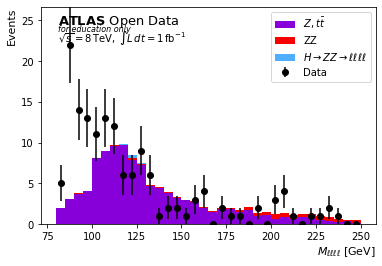

In [16]:
if __name__=="__main__":
    start = time.time()
    data = get_data_from_files()
    plot_data(data)
    elapsed = time.time() - start
    print("Time taken: "+str(elapsed))

## Define the model
We'll start with a dense (fully-connected) NN layer. Our model will have a single fully-connected hidden layer with the same number of neurons as input variables. The weights are initialized using a small Gaussian random number. We will switch between linear and tanh activation functions for the hidden layer. The output layer contains a single neuron in order to make predictions. It uses the sigmoid activation function in order to produce a probability output in the range of 0 to 1.
We are using the *binary_crossentropy* loss function during training, a standard loss function for binary classification problems. We will optimize the model with the Adam algorithm for stochastic gradient descent and we will collect accuracy metrics while the model is trained.

In [19]:
# baseline keras model
from tensorflow import keras
from keras.models import Sequential, Model
# from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils

VARS = ['mllll']

# add isSignal variable
data[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$']['isSignal'] = np.ones(len(data[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$'])) 
data[r'$Z,t\bar{t}$']['isSignal'] = np.zeros(len(data[r'$Z,t\bar{t}$']))
data['ZZ']['isSignal'] = np.zeros(len(data['ZZ']))

NDIM = len(VARS)
inputs = Input(shape=(NDIM,), name = 'input') 
outputs = Dense(1, name = 'output', kernel_initializer='normal', activation='sigmoid')(inputs)

# create the model
model = Model(inputs=inputs, outputs=outputs)
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# print the model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1)]               0         
_________________________________________________________________
output (Dense)               (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


## Dividing the data into testing and training dataset
We will split the data into two parts (one for training+validation and one for testing). We will also apply "standard scaling" preprocessing: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html i.e. making the mean = 0 and the RMS = 1 for all input variables (based **only** on the training/validation dataset). We will also define our early stopping criteria to prevent over-fitting and we will save the model based on the best *val_loss*.

In [20]:
df_all = pd.concat([data[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$'], data[r'$Z,t\bar{t}$'],data['ZZ']])
dataset = df_all.values
X = dataset[:,1:NDIM+1]
Y = dataset[:,NDIM+1]

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
# preprocessing: standard scalar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

# early stopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into dense_model.h5
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('dense_model.h5', monitor='val_loss', 
                                    verbose=0, save_best_only=True, 
                                    save_weights_only=False, mode='auto', 
                                    period=1)

## Run the training
Here, we run the training

In [21]:
# Train classifier
history = model.fit(X_train_val, 
                    Y_train_val, 
                    epochs=1000, 
                    batch_size=1024, 
                    verbose=0, # switch to 1 for more verbosity 
                    callbacks=[early_stopping, model_checkpoint], 
                    validation_split=0.25)

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

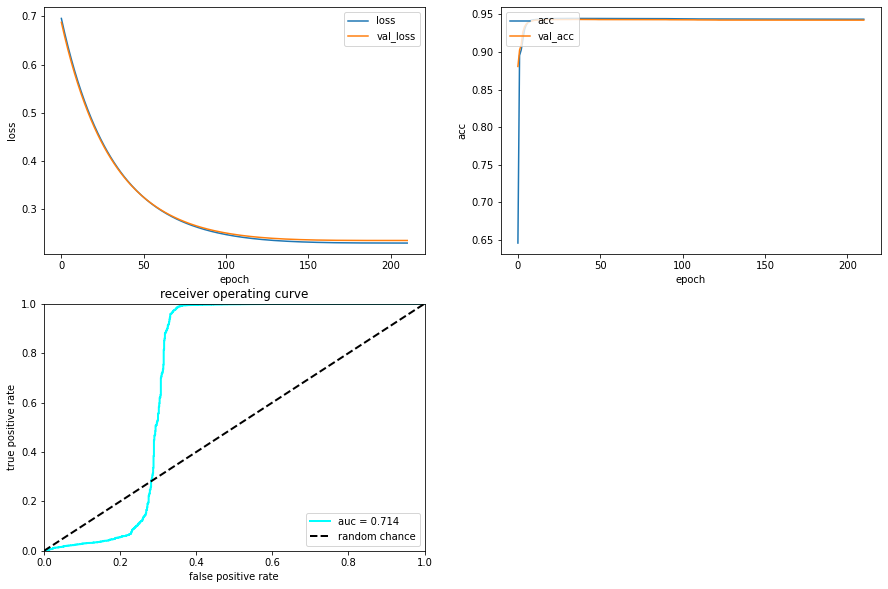

In [24]:
%matplotlib inline
# plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history['accuracy'], label='acc')
ax.plot(history.history['val_accuracy'], label='val_acc')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot ROC
Y_predict = model.predict(X_test)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
ax = plt.subplot(2, 2, 3)
ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
ax.set_title('receiver operating curve')
ax.legend(loc="lower right")
plt.show()